### This notebook contains some of my very rough initial results from using `e3nn-torch` before I decided to switch over to using `e3nn-jax` in order to computer higher order spectra and go to higher $l_{max}$

## Imports

In [2]:
import numpy as np
import pandas as pd
import scipy.linalg
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import torch
import e3nn
from e3nn import o3, io
from tqdm import tqdm
from sklearn.decomposition import PCA
torch.set_default_dtype(torch.float64)

### Define lmax, power spectrum, and bispectrum

In [3]:
def spectra_functions(lmax):
    
    sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)

    powerspectrum_main = o3.ReducedTensorProducts(
        'ij=ji', i=sph, 
        filter_ir_out=['0e', '0o'])
    powerspectrum = lambda x : powerspectrum_main(x, x)


    bispectrum_main = o3.ReducedTensorProducts(
        'ijk=jik=ikj', i=sph, 
        filter_ir_mid=list(o3.Irrep.iterator(lmax)), 
        filter_ir_out=['0e', '0o'])
    bispectrum = lambda x : bispectrum_main(x, x, x)
    
    return sph, powerspectrum, bispectrum

lmax = 4
sph, powerspectrum, bispectrum = spectra_functions(lmax)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


### Debugging

In [177]:
lmax = 6
sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)
powerspectrum_main = o3.ReducedTensorProducts(
    'ij=ji', i=sph, 
    filter_ir_out=['0e', '0o'])
powerspectrum = lambda x : powerspectrum_main(x, x)

In [178]:
# vec = torch.tensor([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1]])

vec = torch.tensor([
    [ 0.12873438, -0.2146625 , 0.],
    [-0.8690867 , -0.60676026, 0.],
    [-1.087478  , -0.4616459 ,  0.],
    [-1.0655355 , -0.159967  ,  0.],
    [ 0.180223  , -1.0559115 ,  0.],
    [-0.97854656, -0.2341107 ,  0.],
    [ 1.163334  , -0.01927068,  0.]])



vec = vec.to(torch.float)

In [179]:
list(sph.with_peaks_at(vec))

[tensor(0.3085),
 tensor(-0.0911),
 tensor(0.1421),
 tensor(0.),
 tensor(0.),
 tensor(-0.3786),
 tensor(-0.5110),
 tensor(0.),
 tensor(-0.6933),
 tensor(0.2165),
 tensor(0.),
 tensor(0.4977),
 tensor(0.0684),
 tensor(0.),
 tensor(-0.1151),
 tensor(0.),
 tensor(0.),
 tensor(0.2576),
 tensor(0.),
 tensor(-0.2457),
 tensor(0.0750),
 tensor(0.),
 tensor(0.4401),
 tensor(0.),
 tensor(0.7640),
 tensor(-0.2237),
 tensor(0.),
 tensor(-0.0642),
 tensor(0.),
 tensor(0.7369),
 tensor(0.2495),
 tensor(0.),
 tensor(0.1053),
 tensor(0.),
 tensor(0.1407),
 tensor(0.),
 tensor(0.),
 tensor(-0.2812),
 tensor(0.),
 tensor(-0.1316),
 tensor(0.),
 tensor(-0.8471),
 tensor(0.5464),
 tensor(0.),
 tensor(0.7172),
 tensor(0.),
 tensor(-0.0185),
 tensor(0.),
 tensor(-0.7605)]

In [148]:
list(sph.sum_of_diracs(vec, torch.norm(vec, dim=1)))

[tensor(0.4254),
 tensor(0.2456),
 tensor(0.2456),
 tensor(0.2456),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(-0.2966),
 tensor(0.),
 tensor(-0.2297),
 tensor(0.3752),
 tensor(-0.2297),
 tensor(0.),
 tensor(0.2966),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.7444),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.6292)]

## Study 1: 2D vs 3D

In [4]:
n = 1000

In [5]:
def random_sphere_points(dimensions):
    
    # Check if dimensions are either 2 or 3
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be either 2 or 3")

    # Generate a random number of rows between 3 and 13
    num_rows = torch.randint(2, 3, size=(1,)).item()

    # Generate a tensor with random values
    tensor = torch.randn(num_rows, dimensions)

    if dimensions == 2:
        # Add an extra column with zeros for 2D points
        tensor = torch.cat((tensor, torch.zeros(num_rows, 1)), dim=1)

    # Normalize each row to have unit norm
    tensor = torch.nn.functional.normalize(tensor, dim=1)

    return tensor


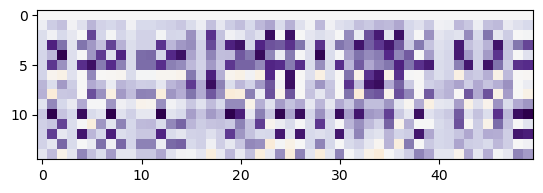

In [6]:
two_dim_points = [random_sphere_points(2) for _ in range(n)]
two_dim_sphs = torch.stack([sph.with_peaks_at(two_dim_points[i]) for i in range(n)], dim=0)
two_dim_bis = bispectrum(two_dim_sphs)
vmax = torch.max(abs(torch.min(two_dim_bis[:50,:])), torch.max(two_dim_bis[:50,:]))
plt.imshow(two_dim_bis[:50,:].T, cmap="PuOr", vmin=-vmax, vmax=vmax)

In [7]:
three_dim_points = [random_sphere_points(3) for _ in range(n)]
three_dim_sphs = torch.stack([sph.with_peaks_at(three_dim_points[i]) for i in range(n)], dim=0)
three_dim_bis = bispectrum(three_dim_sphs)

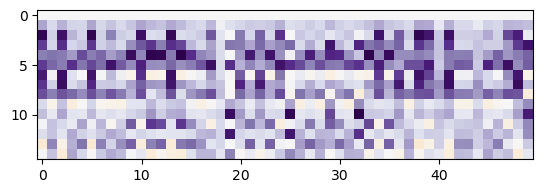

In [10]:
vmax = torch.max(abs(torch.min(three_dim_bis[:50,:])), torch.max(three_dim_bis[:50,:]))
plt.imshow(three_dim_bis[:50,:].T, cmap="PuOr", vmin=-vmax, vmax=vmax)

In [11]:
data = {'dim': n*[2] + n*[3], 'bis': list(two_dim_bis) + list(three_dim_bis)}
df = pd.DataFrame(data=data)

In [12]:
bis = np.array([np.array(b) for b in df.bis])
pca = PCA(n_components=2)
bis_pca = pca.fit_transform(bis)
df["pca1"] = bis_pca[:, 0]
df["pca2"] = bis_pca[:, 1]

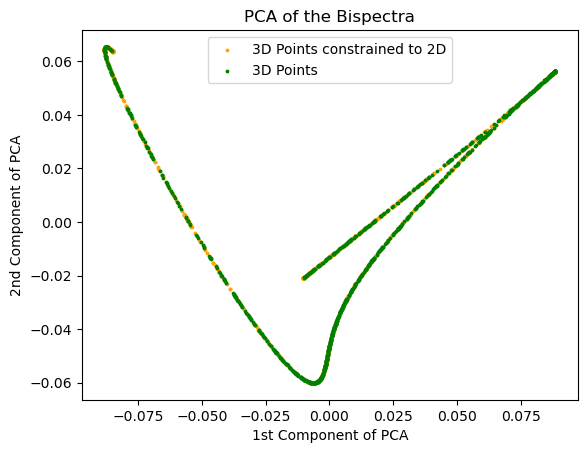

In [13]:
fig = plt.figure()
colors = ["orange", "green"]
labels = ["3D Points constrained to 2D", "3D Points"]

for i, color in enumerate(colors):
    plt.scatter(df[df.dim == i+2].pca1, df[df.dim == i+2].pca2, color=color, s=3, label=labels[i])

plt.title('PCA of the Bispectra')
plt.xlabel('1st Component of PCA')
plt.ylabel('2nd Component of PCA')
plt.legend()

plt.show()


/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty no

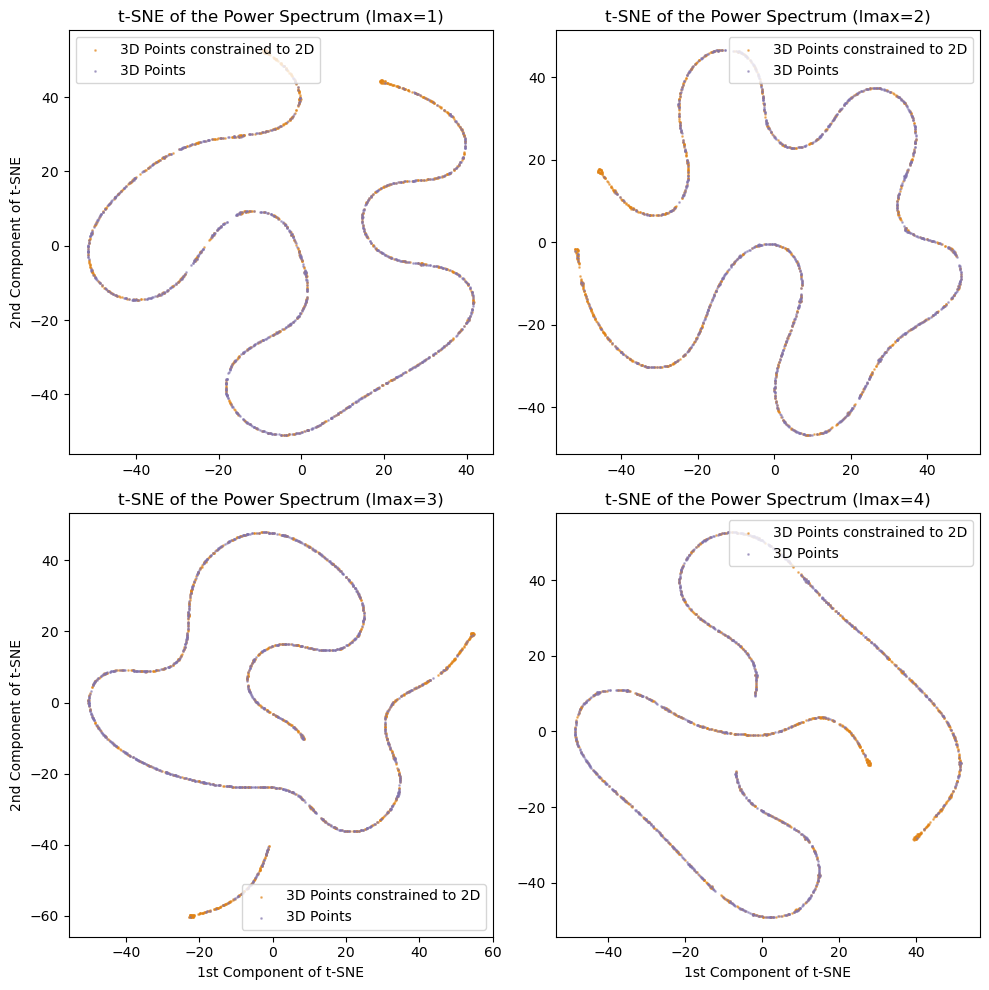

In [15]:
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def calculate_spectra_dim_reduction(lmax, spectrum_function="bispectrum", n=1000, method="PCA"):
    sph, powerspectrum, bispectrum = spectra_functions(lmax)

    if spectrum_function == "power spectrum":
        spectrum = powerspectrum
    else:
        spectrum = bispectrum

    two_dim_points = [random_sphere_points(2) for _ in range(n)]
    two_dim_sphs = torch.stack([sph.with_peaks_at(two_dim_points[i]) for i in range(n)], dim=0)
    two_dim_spectra = spectrum(two_dim_sphs)

    three_dim_points = [random_sphere_points(3) for _ in range(n)]
    three_dim_sphs = torch.stack([sph.with_peaks_at(three_dim_points[i]) for i in range(n)], dim=0)
    three_dim_spectra = spectrum(three_dim_sphs)

    data = {'dim': n*[2] + n*[3], 'spectra': list(two_dim_spectra) + list(three_dim_spectra)}
    df = pd.DataFrame(data=data)

    spectra = np.array([np.array(s) for s in df.spectra])

    if method == "PCA":
        dim_reduction = PCA(n_components=2)
    elif method == "t-SNE":
        dim_reduction = TSNE(n_components=2)
    else:
        raise ValueError("Invalid method specified. Choose either 'pca' or 't-SNE'.")

    spectra_transformed = dim_reduction.fit_transform(spectra)
    df["dim_reduction1"] = spectra_transformed[:, 0]
    df["dim_reduction2"] = spectra_transformed[:, 1]

    return df


def plot_spectra_dim_reduction(df, lmax, spectrum_function, method, ax):
    colors = ["#e08214", "#8073ac"]
    labels = ["3D Points constrained to 2D", "3D Points"]

    for i, color in enumerate(colors):
        ax.scatter(df[df.dim == i+2].dim_reduction1, df[df.dim == i+2].dim_reduction2, color=color, s=1, label=labels[i], alpha=0.5)

    ax.set_title(f'{method} of the {" ".join([s.capitalize() for s in spectrum_function.split()])} (lmax={lmax})')
    return ax

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

lmax_values = [1, 2, 3, 4]
spectrum_function = "power spectrum"
n = 1000
method = "t-SNE"

for row in range(2):
    for col in range(2):
        i = row * 2 + col
        lmax = lmax_values[i]
        ax = axes[row, col]
        df = calculate_spectra_dim_reduction(lmax, spectrum_function, n, method)
        ax = plot_spectra_dim_reduction(df, lmax, spectrum_function, method, ax)
        
        if row == 1:  # The bottom row
            ax.set_xlabel(f'1st Component of {method}')
        if col == 0:  # The leftmost column
            ax.set_ylabel(f'2nd Component of {method}')
        ax.legend()

plt.tight_layout()
plt.show()




In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np

# assume X is a list of numpy arrays and y is a list of labels (2 or 3)
X = np.vstack(data['bis'])
y = np.array(data['dim'])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# encode labels as numeric values
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# train logistic regression classifier
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

# predict labels on test set
y_pred = clf.predict(X_test)

# evaluate performance
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))


Accuracy: 0.60
Precision: 0.61
Recall: 0.60
F1-score: 0.60


## VSEPR Geometries - Clustering

### Base geometries

In [17]:
import numpy as np

linear = np.array([
    [1, 0, 0],
    [-1, 0, 0]
])

# Trigonal planar
trigonal_planar = np.array([
    [1, 0, 0],
    [-0.5, np.sqrt(3)/2, 0],
    [-0.5, -np.sqrt(3)/2, 0]
])

# Bent (assume 120 degrees)
bent = np.array([
    [1, 0, 0],
    [-0.5, np.sqrt(3)/2, 0]
])

# Tetrahedral
tetrahedral = np.array([
    [0, 0, 1],
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Trigonal pyramidal
trigonal_pyramidal = np.array([
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Trigonal bipyramidal
trigonal_bipyramidal = np.array([
    [1, 0, 0],
    [-0.5, np.sqrt(3)/2, 0],
    [-0.5, -np.sqrt(3)/2, 0],
    [0, 0, 1],
    [0, 0, -1]
])

# Seesaw
seesaw = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# T-shaped
t_shaped = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0]
])

# Octahedral
octahedral = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

# Square pyramidal
square_pyramidal = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1]
])

# Square planar
square_planar = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0]
])

In [18]:
vsepr_geometries = {
    "linear": linear,
    "trigonal_planar": trigonal_planar,
    "bent": bent,
    "tetrahedral": tetrahedral,
    "trigonal_pyramidal": trigonal_pyramidal,
    "trigonal_bipyramidal": trigonal_bipyramidal,
    "seesaw": seesaw,
    "t_shaped": t_shaped,
    "octahedral": octahedral,
    "square_pyramidal": square_pyramidal,
    "square_planar": square_planar
}


In [19]:
n = 100
noise = 2e-1
noisy_geometries = {}
names = []
bis = []
lmax = 2
sph, powerspectrum, bispectrum = spectra_functions(lmax)
for name, geometry in tqdm(vsepr_geometries.items()):
    coordination_number = geometry.shape[0]
    for _ in range(n):
        names.append(name)
        rand = np.random.rand(coordination_number, 3)
        noisy_geometry = geometry + rand * noise
        try:
            signal = sph.with_peaks_at(torch.from_numpy(noisy_geometry))
        except:
            print(noisy_geometry)
        bis.append(powerspectrum(signal))        
        # bis.append(bispectrum(signal))        
        
data = {'geometry_name': names, 'bispectrum': bis}
df = pd.DataFrame(data=data)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "
100%|██████████| 11/11 [00:00<00:00, 11.10it/s]


In [20]:
bis = np.array([np.array(b) for b in df.bispectrum])
pca = PCA(n_components=2)
bis_pca = pca.fit_transform(bis)
df["pca1"] = bis_pca[:, 0]
df["pca2"] = bis_pca[:, 1]

In [21]:
tsne = TSNE(n_components=2)
bis_tsne = tsne.fit_transform(bis)
df["tsne1"] = bis_tsne[:, 0]
df["tsne2"] = bis_tsne[:, 1]

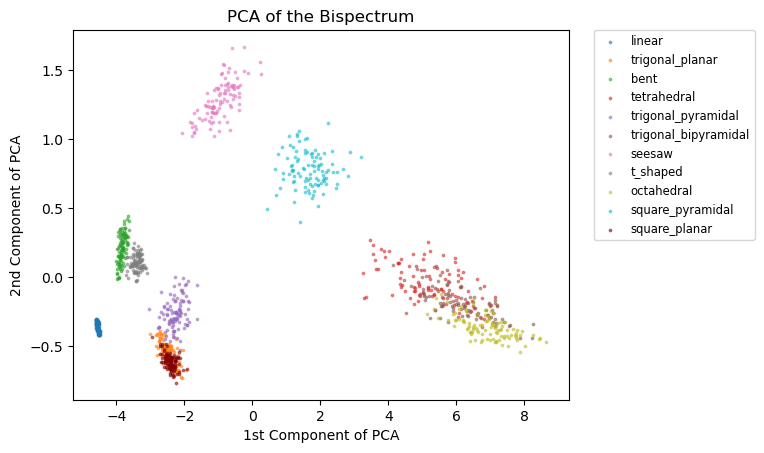

In [22]:
fig = plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#800000']

geometry_names = list(vsepr_geometries.keys())
for name, color in zip(geometry_names, colors):
    plt.scatter(df[df.geometry_name == name].pca1, df[df.geometry_name == name].pca2, color=color, s=3, alpha=0.5)

plt.title('PCA of the Bispectrum')
plt.xlabel('1st Component of PCA')
plt.ylabel('2nd Component of PCA')
plt.legend(geometry_names, fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()


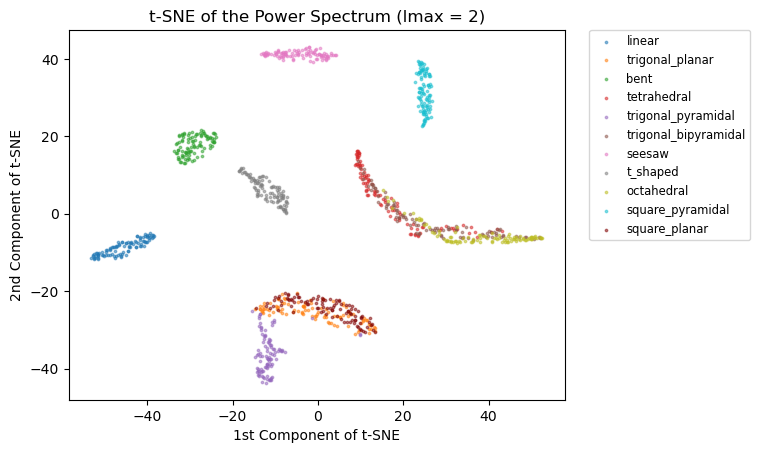

In [23]:
fig = plt.figure()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#800000']

geometry_names = list(vsepr_geometries.keys())
for name, color in zip(geometry_names, colors):
    plt.scatter(df[df.geometry_name == name].tsne1, df[df.geometry_name == name].tsne2, color=color, s=3, alpha=0.5)

plt.title('t-SNE of the Power Spectrum (lmax = 2)')
plt.xlabel('1st Component of t-SNE')
plt.ylabel('2nd Component of t-SNE')
plt.legend(geometry_names, fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()


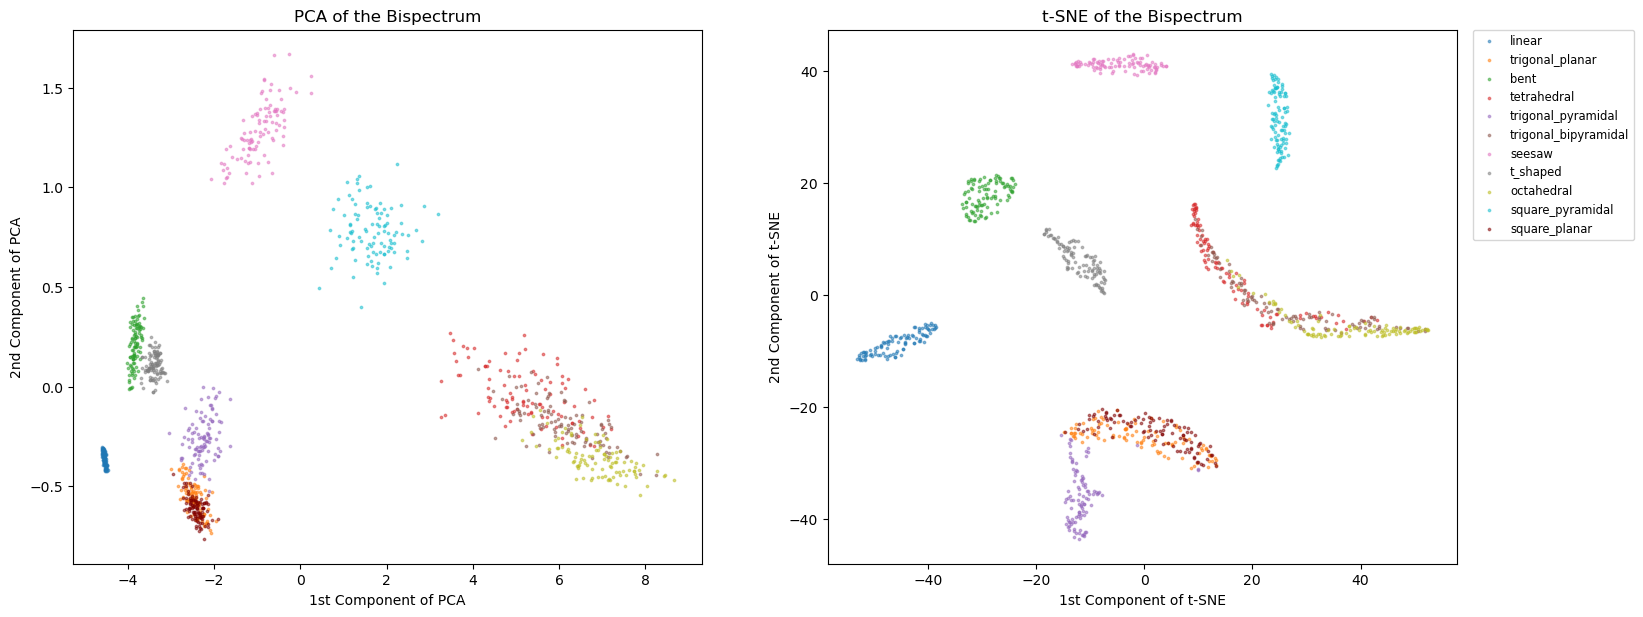

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#800000']
geometry_names = list(vsepr_geometries.keys())

# PCA subplot
for name, color in zip(geometry_names, colors):
    axs[0].scatter(df[df.geometry_name == name].pca1, df[df.geometry_name == name].pca2, color=color, s=3, alpha=0.5)
axs[0].set_title('PCA of the Bispectrum')
axs[0].set_xlabel('1st Component of PCA')
axs[0].set_ylabel('2nd Component of PCA')

# t-SNE subplot
for name, color in zip(geometry_names, colors):
    axs[1].scatter(df[df.geometry_name == name].tsne1, df[df.geometry_name == name].tsne2, color=color, s=3, alpha=0.5)
axs[1].set_title('t-SNE of the Bispectrum')
axs[1].set_xlabel('1st Component of t-SNE')
axs[1].set_ylabel('2nd Component of t-SNE')

# Adjust space between subplots and add a single legend closer to the plots
plt.subplots_adjust(right=0.99, top=1)
legend = fig.legend(geometry_names, fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

plt.show()


In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Preprocess the data: convert the 'bispectrum' column to a list of feature vectors
x = np.vstack(df['bispectrum'].values)

# Preprocess the data: encode the 'geometry_name' column as integer labels
le = LabelEncoder()
y = le.fit_transform(df['geometry_name'])

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train the classifier
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(x_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy * 100))

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 83.18
Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       1.00      1.00      1.00        24
           2       0.68      1.00      0.81        21
           3       1.00      1.00      1.00        14
           4       0.71      0.94      0.81        16
           5       1.00      1.00      1.00        19
           6       1.00      0.77      0.87        22
           7       0.70      0.84      0.76        25
           8       0.70      0.28      0.40        25
           9       0.91      0.53      0.67        19
          10       0.86      1.00      0.92        18

    accuracy                           0.83       220
   macro avg       0.85      0.85      0.83       220
weighted avg       0.84      0.83      0.82       220



/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Study 3: Inverting the Bispectrum

In [26]:
powerspectrum = o3.TensorSquare(sph, filter_ir_out=o3.Irrep.iterator(0))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/torch/jit/_check.py:181: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [27]:
# true_vec = torch.cat([torch.eye(3), -torch.eye(3)], dim=0)
N = 5
true_vec = torch.randn(N, 3)
true_vec /= true_vec.norm(2, -1, keepdim=True)
true_vec *= torch.randn(N, 1)*0.5 + 1.
true_sig = sph.sum_of_diracs(true_vec, values=torch.ones(true_vec.shape[0]))
true_power = powerspectrum(true_sig)
true_bis = bispectrum(true_sig)

In [28]:
other_vec = torch.randn(10, 3)
# cur_sig.requires_grad = True
other_vec.requires_grad = True

In [29]:
opt = torch.optim.Adam([other_vec], lr=1e-2)
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

In [30]:
# true_vec = torch.cat([torch.eye(3), -torch.eye(3)], dim=0)
N = 5
true_vec = torch.randn(N, 3)
true_vec /= true_vec.norm(2, -1, keepdim=True)
true_vec *= torch.randn(N, 1)*0.5 + 1.
true_sig = sph.sum_of_diracs(true_vec, values=torch.ones(true_vec.shape[0]))
true_power = powerspectrum(true_sig)
true_bis = bispectrum(true_sig)

other_vec = torch.randn(10, 3)
# cur_sig.requires_grad = True
other_vec.requires_grad = True

opt = torch.optim.Adam([other_vec], lr=1e-2)
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

max_iter = 2500

for i in range(max_iter):
    cur_sig = sph.sum_of_diracs(other_vec, values=other_vec.norm(2, -1))
    power = powerspectrum(cur_sig)
    bis = bispectrum(cur_sig)
    loss = loss_fn(true_bis, bis) + loss_fn(true_power, power)
    if i % 100 == 0:
        print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

tensor(78.0260, grad_fn=<AddBackward0>)
tensor(5.9579, grad_fn=<AddBackward0>)
tensor(0.5656, grad_fn=<AddBackward0>)
tensor(0.3087, grad_fn=<AddBackward0>)
tensor(0.1225, grad_fn=<AddBackward0>)
tensor(0.0502, grad_fn=<AddBackward0>)
tensor(0.0438, grad_fn=<AddBackward0>)
tensor(0.1475, grad_fn=<AddBackward0>)
tensor(0.0404, grad_fn=<AddBackward0>)
tensor(0.0235, grad_fn=<AddBackward0>)
tensor(0.0672, grad_fn=<AddBackward0>)
tensor(0.0296, grad_fn=<AddBackward0>)
tensor(0.0551, grad_fn=<AddBackward0>)
tensor(0.0733, grad_fn=<AddBackward0>)
tensor(0.0752, grad_fn=<AddBackward0>)
tensor(0.0574, grad_fn=<AddBackward0>)
tensor(0.0932, grad_fn=<AddBackward0>)
tensor(0.1009, grad_fn=<AddBackward0>)
tensor(0.0229, grad_fn=<AddBackward0>)
tensor(0.0650, grad_fn=<AddBackward0>)
tensor(0.0484, grad_fn=<AddBackward0>)
tensor(0.0414, grad_fn=<AddBackward0>)
tensor(0.0158, grad_fn=<AddBackward0>)
tensor(0.0390, grad_fn=<AddBackward0>)
tensor(0.0582, grad_fn=<AddBackward0>)


In [35]:
go.Figure([go.Surface(**sph.plotly_surface(true_sig.detach())[0])])

In [34]:
go.Figure([go.Surface(**sph.plotly_surface(cur_sig.detach())[0])])

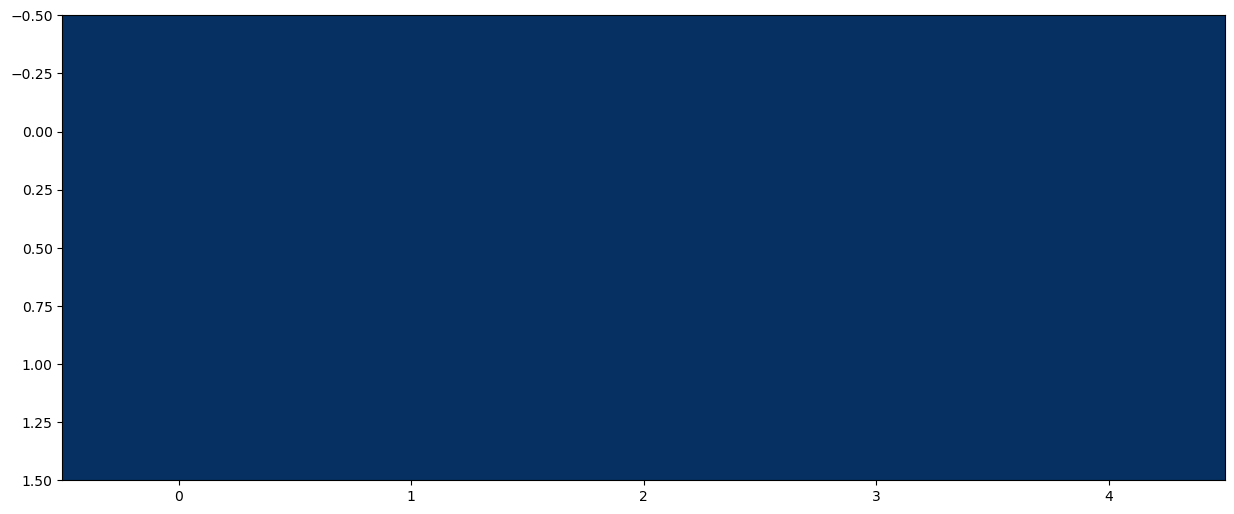

In [31]:
import matplotlib.pyplot as plt

vmax = 1

fig = plt.figure(figsize=(15, 10))
plt.imshow(torch.stack([bispectrum(cur_sig.detach()), bispectrum(true_sig)], dim=0), 
           cmap='RdBu', vmin=-vmax, vmax=vmax)

KeyboardInterrupt: 

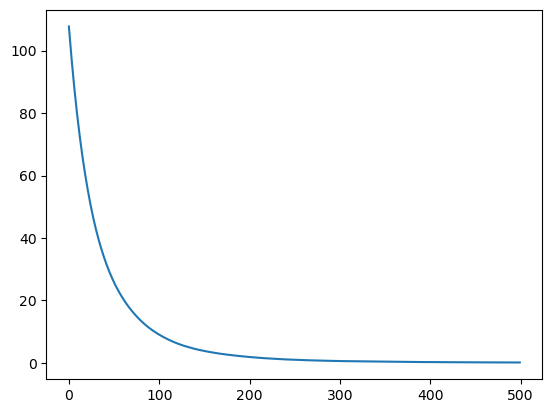

In [32]:
import torch
import matplotlib.pyplot as plt
import random

def generate_data(N):
    true_vec = torch.randn(N, 3)
    true_vec /= true_vec.norm(2, -1, keepdim=True)
    true_vec *= torch.randn(N, 1) * 0.5 + 1.0
    true_sig = sph.sum_of_diracs(true_vec, values=torch.ones(true_vec.shape[0]))
    true_power = powerspectrum(true_sig)
    true_bis = bispectrum(true_sig)
    return true_power, true_bis

def train_loss_terms(loss_type='both', max_iter=2500, num_trials=10):
    loss_fn = torch.nn.L1Loss()
    avg_loss_terms = []

    for trial in range(num_trials):
        N = random.randint(2, 8)  # Generate a random integer between 2 and 8 (inclusive) for N
        true_power, true_bis = generate_data(N)
        other_vec = torch.randn(10, 3)
        other_vec.requires_grad = True
        opt = torch.optim.Adam([other_vec], lr=1e-2)
        trial_loss_terms = []

        for i in range(max_iter):
            cur_sig = sph.sum_of_diracs(other_vec, values=other_vec.norm(2, -1))
            power = powerspectrum(cur_sig)
            bis = bispectrum(cur_sig)
            
            loss_power = loss_fn(true_power, power)
            loss_bis = loss_fn(true_bis, bis)

            if loss_type == 'power':
                loss = loss_power
            elif loss_type == 'bispectrum':
                loss = loss_bis
            else:  # 'both'
                loss = loss_power + loss_bis

            trial_loss_terms.append(loss_bis.item())
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        avg_loss_terms.append(trial_loss_terms)
    
    avg_loss_terms = torch.tensor(avg_loss_terms)
    avg_loss_terms = torch.mean(avg_loss_terms, dim=0)
    return avg_loss_terms

def plot_loss(ax, avg_loss_terms, loss_type):
    x = range(len(avg_loss_terms))
    ax.plot(x, avg_loss_terms, label=f'{loss_type.capitalize()} Loss')

max_iter = 500
num_trials = 10

fig, ax = plt.subplots()

for loss_type in ['bispectrum', 'both']:
    avg_loss_terms = train_loss_terms(loss_type, max_iter, num_trials)
    plot_loss(ax, avg_loss_terms, loss_type)

ax.set_xlabel("Steps")
ax.set_ylabel("Loss")
ax.legend()
plt.show()


## Trispectrum?

In [ ]:
lmax = 4
sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)
trispectrum_main = o3.ReducedTensorProducts(
    'ijkl=jikl=ikjl=ijlk', i=sph, 
    filter_ir_mid=list(o3.Irrep.iterator(lmax)), 
    filter_ir_out=['0e', '0o'])
trispectrum = lambda x : trispectrum_main(x, x, x, x)